In [6]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import pickle
import random
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

In [2]:
def augment_image(img):
    augmented_images = []

    # 1. Flip Horizontally
    flipped = cv2.flip(img, 1)
    augmented_images.append(flipped)

    # 2. Rotate (-30 to +30 degrees)
    angle = random.uniform(-30, 30)
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
    rotated = cv2.warpAffine(img, M, (w, h))
    augmented_images.append(rotated)

    # 3. Adjust Brightness
    # brightness_factor = random.uniform(0.7, 1.3)
    # bright = np.clip(img * brightness_factor, 0, 255).astype(np.uint8)
    # augmented_images.append(bright)

    # 4. Add Gaussian Noise
    # noise = np.random.normal(0, 10, img.shape).astype(np.uint8)
    # noisy = cv2.add(img, noise)
    # augmented_images.append(noisy)

    return augmented_images

In [5]:
#Train Data
train_dataset_path = ["dataset/Rice_Leaf_Diease/train/bacterial_leaf_blight","dataset/Rice_Leaf_Diease/train/brown_spot","dataset/Rice_Leaf_Diease/train/healthy",
                      "dataset/Rice_Leaf_Diease/train/leaf_blast","dataset/Rice_Leaf_Diease/train/leaf_scald","dataset/Rice_Leaf_Diease/train/narrow_brown_spot",
                      "dataset/Rice_Leaf_Diease/train/neck_blast","dataset/Rice_Leaf_Diease/train/rice_hispa","dataset/Rice_Leaf_Diease/train/sheath_blight",
                      "dataset/Rice_Leaf_Diease/train/tungro"]
label = ["bacterial_leaf_blight","brown_spot","healthy","leaf_blast","leaf_scald","narrow_brown_spot","neck_blast","rice_hispa","sheath_blight","tungro",]
train_images_list = []
train_labels_list = []

for i, path in enumerate(train_dataset_path):
    if not os.path.exists(path):
        print(f"Error: Directory not found - {path}")
        continue  # Skip this folder if it doesn't exist

    dir_list = os.listdir(path)
    for img_name in dir_list:
        input_path = os.path.join(path, img_name)

        # Read image
        img = cv2.imread(input_path)
        if img is None:
            print(f"Warning: Could not read image {input_path}")
            continue  # Skip invalid images

        # Convert BGR to RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize to a fixed size (128x128)
        img_rgb = cv2.resize(img_rgb, (64, 64))

        # Append original image
        train_images_list.append(img_rgb)
        train_labels_list.append(label[i])

        # Apply augmentations and add to dataset
        augmented_images = augment_image(img_rgb)
        for aug_img in augmented_images:
            train_images_list.append(aug_img)
            train_labels_list.append(label[i])

# Convert lists to NumPy arrays for training
X = np.array(train_images_list)
y = np.array(train_labels_list)

print(f"Dataset size for Training: {len(X)} images")

Dataset size for Training: 45069 images


In [7]:
#Validation Data
test_dataset_path = ["dataset/Rice_Leaf_Diease/test/bacterial_leaf_blight","dataset/Rice_Leaf_Diease/test/brown_spot","dataset/Rice_Leaf_Diease/test/healthy",
                      "dataset/Rice_Leaf_Diease/test/leaf_blast","dataset/Rice_Leaf_Diease/test/leaf_scald","dataset/Rice_Leaf_Diease/test/narrow_brown_spot",
                      "dataset/Rice_Leaf_Diease/test/neck_blast","dataset/Rice_Leaf_Diease/test/Rice Hispa","dataset/Rice_Leaf_Diease/test/Sheath Blight",
                      "dataset/Rice_Leaf_Diease/test/tungro"]
# label = ["bacterial_leaf_blight","brown_spot","healthy","leaf_blast","leaf_scald","narrow_brown_spot","neck_blast","rice_hispa","sheath_blight","tungro",]
test_images_list = []
test_labels_list = []

for i, path in enumerate(test_dataset_path):
    if not os.path.exists(path):
        print(f"Error: Directory not found - {path}")
        continue  # Skip this folder if it doesn't exist

    dir_list = os.listdir(path)
    for img_name in dir_list:
        input_path = os.path.join(path, img_name)

        # Read image
        img = cv2.imread(input_path)
        if img is None:
            print(f"Warning: Could not read image {input_path}")
            continue  # Skip invalid images

        # Convert BGR to RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize to a fixed size (128x128)
        img_rgb = cv2.resize(img_rgb, (128, 128))

        # Append original image
        test_images_list.append(img_rgb)
        test_labels_list.append(label[i])

# Convert lists to NumPy arrays for Validation
Validation_image = np.array(test_images_list)
Validation_label = np.array(test_labels_list)

print(f"Dataset size for Validation: {len(Validation_image)} images")

Dataset size for Validation: 3422 images


In [8]:
# Generate a dictionary with images split into categories
image_label_dict = {}
for l in label:
    image_label_dict[l] = [train_images_list[i] for i, x in enumerate(train_labels_list) if x == l]

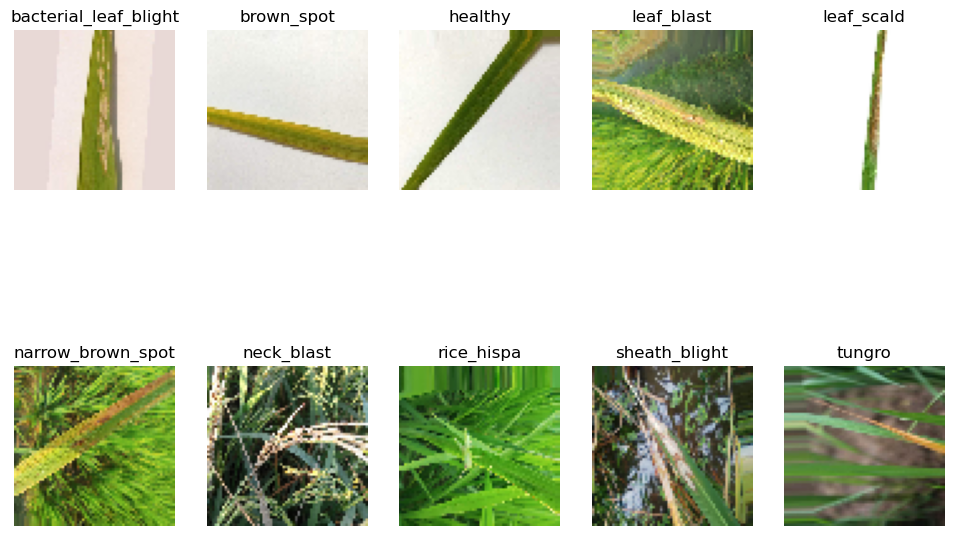

In [9]:
# Plot images
plt.figure(figsize=(12, 8))

for i, l in enumerate(label):
    if len(image_label_dict[l]) > 0:  # Ensure there's at least one image
        plt.subplot(2, 5, i + 1)
        plt.imshow(image_label_dict[l][0])
        plt.axis('off')
        plt.title(l)

plt.show()

In [10]:
print("Dictionary Keys:", image_label_dict.keys())
print("Labels List:", label)

Dictionary Keys: dict_keys(['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot', 'neck_blast', 'rice_hispa', 'sheath_blight', 'tungro'])
Labels List: ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot', 'neck_blast', 'rice_hispa', 'sheath_blight', 'tungro']


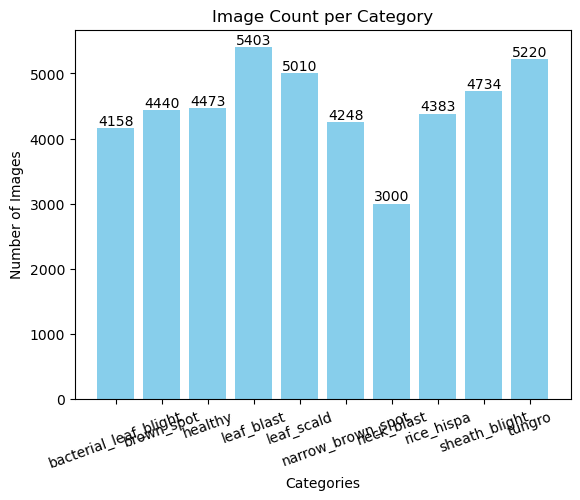

In [11]:
# Count the number of images per category
image_counts = [len(image_label_dict[l]) for l in label]

# Create bar chart
fig, ax = plt.subplots()
bars = ax.bar(label, image_counts, color='skyblue')

# Add labels on bars
ax.bar_label(bars)

# Improve visualization
ax.set_ylabel("Number of Images")
ax.set_xlabel("Categories")
ax.set_title("Image Count per Category")
plt.xticks(rotation=20)  # Rotate labels if needed
plt.show()

before Augumentation
[1584, 1440, 1600, 1308]

In [12]:
image_counts

[4158, 4440, 4473, 5403, 5010, 4248, 3000, 4383, 4734, 5220]

In [13]:
# Define class labels
classes = np.array([0, 1, 2, 3,4,5,6,7,8,9])  # Assuming 4 classes

# Define the labels for each image (list of actual class labels)
labels = np.concatenate([
    np.full(4158, 0),  # 4752 images of class 0
    np.full(4440, 1),  # 4320 images of class 1
    np.full(4473, 2),  # 4800 images of class 2
    np.full(5403, 3),   # 3924 images of class 3
    np.full(5010, 4),    #4464 images of class 4
    np.full(4248,5),
    np.full(3000,6),
    np.full(4383,7),
    np.full(4734,8),
    np.full(5220,9),
])

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels)

# Convert to dictionary format
class_weight_dict = {i: w for i, w in enumerate(class_weights)}

print(class_weight_dict)

{0: 1.083910533910534, 1: 1.0150675675675676, 2: 1.0075788061703554, 3: 0.8341476957245975, 4: 0.8995808383233533, 5: 1.0609463276836157, 6: 1.5023, 7: 1.028268309377139, 8: 0.9520278833967047, 9: 0.8633908045977011}


In [15]:
# Step 1: Convert to NumPy array
images_array = np.array(train_images_list)  # Resize to 128x128

In [16]:
images_array = images_array / 255.0  # Normalize pixel values

In [17]:
# Step 2: Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(train_labels_list)  # Convert text labels to numbers
labels_encoded = to_categorical(labels_encoded, num_classes= 10)

In [19]:
# Step 1: Convert to NumPy array
Validation_image = np.array(Validation_image)  # Resize to 128x128


In [20]:
Validation_image = Validation_image / 255.0  # Normalize pixel values

In [21]:
# Step 2: Encode labels
label_encoder = LabelEncoder()
Validation_label = label_encoder.fit_transform(Validation_label)  # Convert text labels to numbers
Validation_label = to_categorical(Validation_label, num_classes= 10)

In [22]:
x_train, x_test, y_train, y_test = train_test_split(images_array, labels_encoded, test_size = 0.2, random_state = 42)

In [23]:
print("Length of original set: ", images_array.shape, "y:", labels_encoded.shape)
print("Length of train set: ", x_train.shape, "y:", y_train.shape)
print("Length of test set: ", x_test.shape, "y:", y_test.shape)

Length of original set:  (45069, 64, 64, 3) y: (45069, 10)
Length of train set:  (36055, 64, 64, 3) y: (36055, 10)
Length of test set:  (9014, 64, 64, 3) y: (9014, 10)


In [24]:
# Load the VGG16 model without the top layers
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(64, 64, 3))

In [25]:
# Freeze the convolutional base
base_model.trainable = False

In [ ]:
# Define the new model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(4096, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(2048, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1024, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(10, activation="softmax"))  # 10 classes

In [27]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     2,101,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,343,690 (104.31 MB)

 Trainable params: 12,614,666 (48.12 MB)

 Non-trainable params: 14,729,024 (56.19 MB)

In [29]:
hist = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=16, class_weight=class_weight_dict)

Epoch 1/10
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 1277s 555ms/step - accuracy: 0.5617 - loss: 1.3854 - val_accuracy: 0.7600 - val_loss: 0.7047
Epoch 2/10
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 1212s 538ms/step - accuracy: 0.7175 - loss: 0.8009 - val_accuracy: 0.8092 - val_loss: 0.5611
Epoch 3/10
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 1216s 539ms/step - accuracy: 0.7695 - loss: 0.6473 - val_accuracy: 0.8347 - val_loss: 0.4667
Epoch 4/10
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 1217s 540ms/step - accuracy: 0.7980 - loss: 0.5403 - val_accuracy: 0.8361 - val_loss: 0.4445
Epoch 5/10
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 1217s 540ms/step - accuracy: 0.8253 - loss: 0.4708 - val_accuracy: 0.8638 - val_loss: 0.3929
Epoch 6/10
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 1320s 586ms/step - accuracy: 0.8488 - loss: 0.4066 - val_accuracy: 0.8833 - val_loss: 0.3304
Epoch 7/10
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 1514s 672ms/step - accuracy: 0.8552 - loss: 0.3817 - val_accuracy: 0.8796 - val_loss: 0.3281
Epoch 8/10
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 1599s 709ms/s

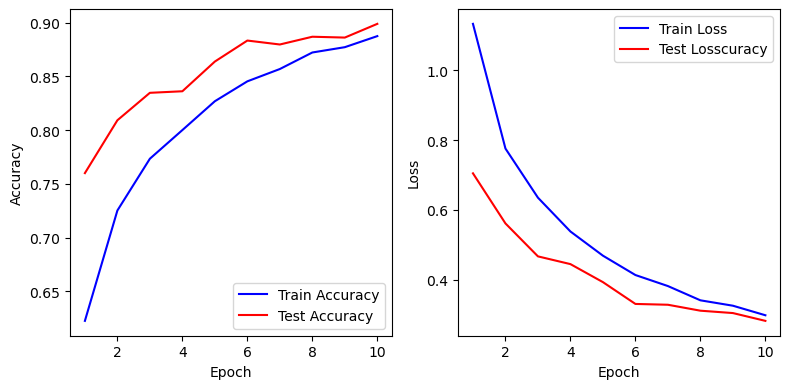

In [30]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1,len(acc) + 1)
#Creating subplots
fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))
axes[0].plot(epochs, acc, 'b', label = 'Train Accuracy')
axes[0].plot(epochs, val_acc, 'r', label = 'Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, 'b', label = 'Train Loss')
axes[1].plot(epochs, val_loss, 'r', label = 'Test Losscuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

#Adjust layout for better spacing
plt.tight_layout()
#display figure
plt.show()

In [31]:
y_pred = model.predict(x_test)

282/282 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step


In [32]:
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       860
           1       0.83      0.84      0.83       919
           2       0.78      0.90      0.84       866
           3       0.89      0.66      0.76      1056
           4       0.95      0.95      0.95      1003
           5       0.88      0.85      0.86       846
           6       1.00      1.00      1.00       616
           7       0.91      0.96      0.94       888
           8       0.89      0.94      0.91       935
           9       0.97      0.98      0.97      1025

    accuracy                           0.90      9014
   macro avg       0.90      0.90      0.90      9014
weighted avg       0.90      0.90      0.90      9014



In [33]:
print(confusion_matrix(y_pred,y_test))

[[ 843   17    5   13   12   23    1    0    0    2]
 [   4  768   28   88    2   34    0    0    1    0]
 [   2   52  782  145    3    3    0    8    3    3]
 [   2   35   13  697    2   15    1    1    7    7]
 [   7    6    3    7  949   14    0    6    6    3]
 [   0   36    0   43   12  718    0    1    7    0]
 [   1    0    0    0    0    0  614    0    1    1]
 [   0    1   25   14    7    8    0  852   23    3]
 [   1    2    7   45   13   22    0   19  877    4]
 [   0    2    3    4    3    9    0    1   10 1002]]


In [34]:
val_y_pred = model.predict(Validation_image)

107/107 ━━━━━━━━━━━━━━━━━━━━ 73s 678ms/step


In [35]:
val_y_test = np.argmax(Validation_label, axis=1)
val_y_pred = np.argmax(val_y_pred, axis=1)
val_report = classification_report(val_y_test,val_y_pred)
print(val_report)

              precision    recall  f1-score   support

           0       0.91      0.96      0.94       376
           1       0.75      0.82      0.78       380
           2       0.67      0.86      0.75       391
           3       0.88      0.48      0.62       362
           4       0.97      0.91      0.94       386
           5       0.86      0.85      0.85       382
           6       1.00      1.00      1.00       322
           7       0.64      0.53      0.58       225
           8       0.66      0.55      0.60       288
           9       0.72      0.98      0.83       310

    accuracy                           0.81      3422
   macro avg       0.81      0.79      0.79      3422
weighted avg       0.81      0.81      0.80      3422



In [36]:
print(confusion_matrix(val_y_pred,val_y_test))

[[361  11   1  10   4   1   0   0   8   0]
 [  7 312  11  51   2  25   0   0  10   0]
 [  1  14 335  93   1   6   0  31  15   1]
 [  0   8   5 175   1   5   0   0   2   2]
 [  6   2   0   0 351   1   0   0   3   0]
 [  1  20   0  18   3 326   0   4   9   0]
 [  0   1   0   0   0   0 322   0   0   0]
 [  0   1  13   5   3   2   0 119  39   4]
 [  0   4   8  10  13  10   0  35 158   0]
 [  0   7  18   0   8   6   0  36  44 303]]


In [37]:
pickle_out = open("modelv16.pkl", "wb")
pickle.dump(model, pickle_out)
pickle_out.close()